In [5]:
%matplotlib inline

In [6]:
from typing import List, Optional, Iterable, Dict, Any
from itertools import islice

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import tqdm.auto as tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

from gluonts.core.component import validated
from gluonts.dataset.common import Dataset
from gluonts.dataset.field_names import FieldName
from gluonts.itertools import Cyclic, PseudoShuffled, IterableSlice
from gluonts.time_feature import (
    TimeFeature,
    time_features_from_frequency_str,
)
from gluonts.torch.modules.loss import DistributionLoss, NegativeLogLikelihood
from gluonts.transform import (
    Transformation,
    Chain,
    RemoveFields,
    SetField,
    AsNumpyArray,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AddAgeFeature,
    VstackFeatures,
    InstanceSplitter,
    ValidationSplitSampler,
    TestSplitSampler,
    ExpectedNumInstanceSampler,
    SelectFields,
    InstanceSampler,
)
from gluonts.torch.util import (
    IterableDataset,
)
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.torch.model.estimator import PyTorchLightningEstimator
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.torch.modules.distribution_output import (
    DistributionOutput,
    StudentTOutput,
)
from gluonts.torch.util import weighted_average
from gluonts.torch.modules.scaler import MeanScaler, NOPScaler
from gluonts.torch.modules.feature import FeatureEmbedder
from gluonts.time_feature import get_lags_for_frequency
from gluonts.dataset.repository.datasets import get_dataset

/home/kashif/.env/pytorch/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [7]:
class TransformerModel(nn.Module):
    @validated()
    def __init__(
        self,
        freq: str,
        context_length: int,
        prediction_length: int,
        num_feat_dynamic_real: int,
        num_feat_static_real: int,
        num_feat_static_cat: int,
        cardinality: List[int],
        
        # transformer arguments
        nhead: int,
        num_encoder_layers: int,
        num_decoder_layers: int,
        dim_feedforward: int,
        activation: str = "gelu",
        dropout: float = 0.1,

        # univariate input
        input_size: int = 1,
        embedding_dimension: Optional[List[int]] = None,
        distr_output: DistributionOutput = StudentTOutput(),
        lags_seq: Optional[List[int]] = None,
        scaling: bool = True,
        num_parallel_samples: int = 100,
    ) -> None:
        super().__init__()
        
        self.input_size = input_size
       
        self.target_shape = distr_output.event_shape
        self.num_feat_dynamic_real = num_feat_dynamic_real
        self.num_feat_static_cat = num_feat_static_cat
        self.num_feat_static_real = num_feat_static_real
        self.embedding_dimension = (
            embedding_dimension
            if embedding_dimension is not None or cardinality is None
            else [min(50, (cat + 1) // 2) for cat in cardinality]
        )
        self.lags_seq = lags_seq or get_lags_for_frequency(freq_str=freq)
        self.num_parallel_samples = num_parallel_samples
        self.history_length = context_length + max(self.lags_seq)
        self.embedder = FeatureEmbedder(
            cardinalities=cardinality,
            embedding_dims=self.embedding_dimension,
        )
        if scaling:
            self.scaler = MeanScaler(dim=1, keepdim=True)
        else:
            self.scaler = NOPScaler(dim=1, keepdim=True)
        
        # total feature size
        d_model = self.input_size * len(self.lags_seq) + self._number_of_features
        
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.param_proj = distr_output.get_args_proj(d_model)
            
        # transformer enc-decoder and mask initializer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=True,
        )
        
        # causal decoder tgt mask
        self.register_buffer(
            "tgt_mask",
            self.transformer.generate_square_subsequent_mask(prediction_length),
        )
        
    @property
    def _number_of_features(self) -> int:
        return (
            sum(self.embedding_dimension)
            + self.num_feat_dynamic_real
            + self.num_feat_static_real
            + 1  # the log(scale)
        )

    @property
    def _past_length(self) -> int:
        return self.context_length + max(self.lags_seq)
    
    def get_lagged_subsequences(
        self,
        sequence: torch.Tensor,
        subsequences_length: int,
        shift: int = 0
    ) -> torch.Tensor:
        """
        Returns lagged subsequences of a given sequence.
        Parameters
        ----------
        sequence : Tensor
            the sequence from which lagged subsequences should be extracted.
            Shape: (N, T, C).
        subsequences_length : int
            length of the subsequences to be extracted.
        shift: int
            shift the lags by this amount back.
        Returns
        --------
        lagged : Tensor
            a tensor of shape (N, S, C, I), where S = subsequences_length and
            I = len(indices), containing lagged subsequences. Specifically,
            lagged[i, j, :, k] = sequence[i, -indices[k]-S+j, :].
        """
        sequence_length = sequence.shape[1]
        indices = [l - shift for l in self.lags_seq]

        assert max(indices) + subsequences_length <= sequence_length, (
            f"lags cannot go further than history length, found lag {max(indices)} "
            f"while history length is only {sequence_length}"
        )

        lagged_values = []
        for lag_index in indices:
            begin_index = -lag_index - subsequences_length
            end_index = -lag_index if lag_index > 0 else None
            lagged_values.append(sequence[:, begin_index:end_index, ...])
        return torch.stack(lagged_values, dim=-1)

    def _check_shapes(
        self,
        prior_input: torch.Tensor,
        inputs: torch.Tensor,
        features: Optional[torch.Tensor],
    ) -> None:
        assert len(prior_input.shape) == len(inputs.shape)
        assert (
            len(prior_input.shape) == 2 and self.input_size == 1
        ) or prior_input.shape[2] == self.input_size
        assert (len(inputs.shape) == 2 and self.input_size == 1) or inputs.shape[
            -1
        ] == self.input_size
        assert (
            features is None or features.shape[2] == self._number_of_features
        ), f"{features.shape[2]}, expected {self._number_of_features}"
    
    
    def create_network_inputs(
        self, 
        feat_static_cat: torch.Tensor, 
        feat_static_real: torch.Tensor,
        past_time_feat: torch.Tensor,
        past_target: torch.Tensor,
        past_observed_values: torch.Tensor,
        future_time_feat: Optional[torch.Tensor] = None,
        future_target: Optional[torch.Tensor] = None,
    ):        
        # time feature
        time_feat = (
            torch.cat(
                (
                    past_time_feat[:, self._past_length - self.context_length :, ...],
                    future_time_feat,
                ),
                dim=1,
            )
            if future_target is not None
            else past_time_feat[:, self._past_length - self.context_length :, ...]
        )

        # target
        context = past_target[:, -self.context_length :]
        observed_context = past_observed_values[:, -self.context_length :]
        _, scale = self.scaler(context, observed_context)

        inputs = (
            torch.cat((past_target, future_target), dim=1) / scale
            if future_target is not None
            else past_target / scale
        )

        inputs_length = (
            self._past_length + self.prediction_length
            if future_target is not None
            else self._past_length
        )
        assert inputs.shape[1] == inputs_length
        
        subsequences_length = (
            self.context_length + self.prediction_length
            if future_target is not None
            else self.context_length
        )
        
        # embeddings
        embedded_cat = self.embedder(feat_static_cat)
        static_feat = torch.cat(
            (embedded_cat, feat_static_real, scale.log()),
            dim=1,
        )
        expanded_static_feat = static_feat.unsqueeze(1).expand(
            -1, time_feat.shape[1], -1
        )
        
        
        features = torch.cat((expanded_static_feat, time_feat), dim=-1)
        
        
        #self._check_shapes(prior_input, inputs, features)

        #sequence = torch.cat((prior_input, inputs), dim=1)
        lagged_sequence = self.get_lagged_subsequences(
            sequence=inputs,
            subsequences_length=subsequences_length,
        )

        lags_shape = lagged_sequence.shape
        reshaped_lagged_sequence = lagged_sequence.reshape(
            lags_shape[0], lags_shape[1], -1
        )


        transformer_inputs = torch.cat((reshaped_lagged_sequence, features), dim=-1)
        
        return transformer_inputs, scale, static_feat
    
    def output_params(self, transformer_inputs):
        enc_input = transformer_inputs[:, :self.context_length, ...]
        dec_input = transformer_inputs[:, self.context_length:, ...]
        
        enc_out = self.transformer.encoder(
            enc_input
        )
        dec_output = self.transformer.decoder(
            dec_input,
            enc_out,
            tgt_mask=self.tgt_mask
        )
        
        return self.param_proj(dec_output)

    @torch.jit.ignore
    def output_distribution(
        self, params, scale=None, trailing_n=None
    ) -> torch.distributions.Distribution:
        sliced_params = params
        if trailing_n is not None:
            sliced_params = [p[:, -trailing_n:] for p in params]
        return self.distr_output.distribution(sliced_params, scale=scale)
    
    # for prediction
    def forward(
        self,
        feat_static_cat: torch.Tensor,
        feat_static_real: torch.Tensor,
        past_time_feat: torch.Tensor,
        past_target: torch.Tensor,
        past_observed_values: torch.Tensor,
        future_time_feat: torch.Tensor,
        num_parallel_samples: Optional[int] = None,
    ) -> torch.Tensor:
        
        
        if num_parallel_samples is None:
            num_parallel_samples = self.num_parallel_samples
            
        encoder_inputs, scale, static_feat = self.create_network_inputs(
            feat_static_cat,
            feat_static_real,
            past_time_feat,
            past_target,
            past_observed_values,
        )
        
        enc_out = self.transformer.encoder(encoder_inputs)
        
        repeated_scale = scale.repeat_interleave(
            repeats=self.num_parallel_samples, dim=0
        )
        repeated_static_feat = static_feat.repeat_interleave(
            repeats=self.num_parallel_samples, dim=0
        ).unsqueeze(dim=1)
        repeated_past_target = (
            past_target.repeat_interleave(
                repeats=self.num_parallel_samples, dim=0
            )
            / repeated_scale
        )
        repeated_time_feat = future_time_feat.repeat_interleave(
            repeats=self.num_parallel_samples, dim=0
        )
        repeated_enc_out = enc_out.repeat_interleave(
            repeats=self.num_parallel_samples, dim=0
        )

        future_samples = []
        
        for k in range(self.prediction_length):
            next_features = torch.cat(
                (repeated_static_feat, repeated_time_feat[:, k : k + 1]),
                dim=-1,
            )
            
            #self._check_shapes(repeated_past_target, next_sample, next_features)
            #sequence = torch.cat((repeated_past_target, next_sample), dim=1)
            
            lagged_sequence = self.get_lagged_subsequences(
                sequence=repeated_past_target,
                subsequences_length=1,
                shift=1, 
            )

            lags_shape = lagged_sequence.shape
            reshaped_lagged_sequence = lagged_sequence.reshape(
                lags_shape[0], lags_shape[1], -1
            )
            
            decoder_input = torch.cat((reshaped_lagged_sequence, next_features), dim=-1)

            output = self.transformer.decoder(decoder_input, repeated_enc_out)
            
            params = self.param_proj(output)
            distr = self.output_distribution(params, scale=repeated_scale)
            next_sample = distr.sample()
            
            repeated_past_target = torch.cat(
                (repeated_past_target, next_sample / repeated_scale), dim=1
            )
            future_samples.append(next_sample)

        concat_future_samples = torch.cat(future_samples, dim=1)
        return concat_future_samples.reshape(
            (-1, self.num_parallel_samples, self.prediction_length)
            + self.target_shape,
        )

In [8]:
class TransformerLightningModule(pl.LightningModule):
    def __init__(
        self,
        model: TransformerModel,
        loss: DistributionLoss = NegativeLogLikelihood(),
        lr: float = 1e-3,
        weight_decay: float = 1e-8,
    ) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.loss = loss
        self.lr = lr
        self.weight_decay = weight_decay
        
    def training_step(self, batch, batch_idx: int):
        """Execute training step"""
        train_loss = self(batch)
        self.log(
            "train_loss",
            train_loss,
            on_epoch=True,
            on_step=False,
            prog_bar=True,
        )
        return train_loss

    def validation_step(self, batch, batch_idx: int):
        """Execute validation step"""
        with torch.inference_mode():
            val_loss = self(batch)
        self.log(
            "val_loss", val_loss, on_epoch=True, on_step=False, prog_bar=True
        )
        return val_loss

    def configure_optimizers(self):
        """Returns the optimizer to use"""
        return torch.optim.Adam(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay,
        )

    def forward(self, batch):
        feat_static_cat = batch["feat_static_cat"]
        feat_static_real = batch["feat_static_real"]
        past_time_feat = batch["past_time_feat"]
        past_target = batch["past_target"]
        future_time_feat = batch["future_time_feat"]
        future_target = batch["future_target"]
        past_observed_values = batch["past_observed_values"]
        future_observed_values = batch["future_observed_values"]
        
        transformer_inputs, scale, _ = self.model.create_network_inputs(
            feat_static_cat,
            feat_static_real,
            past_time_feat,
            past_target,
            past_observed_values,
            future_time_feat,
            future_target,
        )
        params = self.model.output_params(transformer_inputs)
        distr = self.model.output_distribution(params, scale)

        loss_values = self.loss(distr, future_target)
    
        if len(self.model.target_shape) == 0:
            loss_weights = future_observed_values
        else:
            loss_weights = future_observed_values.min(dim=-1, keepdim=False)

        return weighted_average(loss_values, weights=loss_weights)

In [9]:
PREDICTION_INPUT_NAMES = [
    "feat_static_cat",
    "feat_static_real",
    "past_time_feat",
    "past_target",
    "past_observed_values",
    "future_time_feat",
]

TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
    "future_target",
    "future_observed_values",
]

In [10]:
class TransformerEstimator(PyTorchLightningEstimator):
    @validated()
    def __init__(
        self,
        freq: str,
        prediction_length: int,
        
        # Transformer arguments
        nhead: int,
        num_encoder_layers: int,
        num_decoder_layers: int,
        dim_feedforward: int,
        input_size: int = 1,
        activation: str = "gelu",
        dropout: float = 0.1,

        context_length: Optional[int] = None,

        num_feat_dynamic_real: int = 0,
        num_feat_static_cat: int = 0,
        num_feat_static_real: int = 0,
        cardinality: Optional[List[int]] = None,
        embedding_dimension: Optional[List[int]] = None,
        distr_output: DistributionOutput = StudentTOutput(),
        loss: DistributionLoss = NegativeLogLikelihood(),
        scaling: bool = True,
        lags_seq: Optional[List[int]] = None,
        time_features: Optional[List[TimeFeature]] = None,
        num_parallel_samples: int = 100,
        batch_size: int = 32,
        num_batches_per_epoch: int = 50,
        trainer_kwargs: Optional[Dict[str, Any]] = dict(),
        train_sampler: Optional[InstanceSampler] = None,
        validation_sampler: Optional[InstanceSampler] = None,
    ) -> None:
        trainer_kwargs = {
            "max_epochs": 100,
            **trainer_kwargs,
        }
        super().__init__(trainer_kwargs=trainer_kwargs)
        
        self.freq = freq
        self.context_length = (
            context_length if context_length is not None else prediction_length
        )
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.loss = loss
        
        self.input_size = input_size
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.activation = activation
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        
        self.num_feat_dynamic_real = num_feat_dynamic_real
        self.num_feat_static_cat = num_feat_static_cat
        self.num_feat_static_real = num_feat_static_real
        self.cardinality = (
            cardinality if cardinality and num_feat_static_cat > 0 else [1]
        )
        self.embedding_dimension = embedding_dimension
        self.scaling = scaling
        self.lags_seq = lags_seq
        self.time_features = (
            time_features
            if time_features is not None
            else time_features_from_frequency_str(self.freq)
        )

        self.num_parallel_samples = num_parallel_samples
        self.batch_size = batch_size
        self.num_batches_per_epoch = num_batches_per_epoch

        self.train_sampler = train_sampler or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=prediction_length
        )
        self.validation_sampler = validation_sampler or ValidationSplitSampler(
            min_future=prediction_length
        )
        
    def create_transformation(self) -> Transformation:
        remove_field_names = []
        if self.num_feat_static_real == 0:
            remove_field_names.append(FieldName.FEAT_STATIC_REAL)
        if self.num_feat_dynamic_real == 0:
            remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)

        return Chain(
            [RemoveFields(field_names=remove_field_names)]
            + (
                [SetField(output_field=FieldName.FEAT_STATIC_CAT, value=[0])]
                if not self.num_feat_static_cat > 0
                else []
            )
            + (
                [
                    SetField(
                        output_field=FieldName.FEAT_STATIC_REAL, value=[0.0]
                    )
                ]
                if not self.num_feat_static_real > 0
                else []
            )
            + [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                ),
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                ),
                AsNumpyArray(
                    field=FieldName.TARGET,
                    # in the following line, we add 1 for the time dimension
                    expected_ndim=1 + len(self.distr_output.event_shape),
                ),
                AddObservedValuesIndicator(
                    target_field=FieldName.TARGET,
                    output_field=FieldName.OBSERVED_VALUES,
                ),
                AddTimeFeatures(
                    start_field=FieldName.START,
                    target_field=FieldName.TARGET,
                    output_field=FieldName.FEAT_TIME,
                    time_features=self.time_features,
                    pred_length=self.prediction_length,
                ),
                AddAgeFeature(
                    target_field=FieldName.TARGET,
                    output_field=FieldName.FEAT_AGE,
                    pred_length=self.prediction_length,
                    log_scale=True,
                ),
                VstackFeatures(
                    output_field=FieldName.FEAT_TIME,
                    input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                    + (
                        [FieldName.FEAT_DYNAMIC_REAL]
                        if self.num_feat_dynamic_real > 0
                        else []
                    ),
                ),
            ]
        )

    def _create_instance_splitter(
        self, module: TransformerLightningModule, mode: str
    ):
        assert mode in ["training", "validation", "test"]

        instance_sampler = {
            "training": self.train_sampler,
            "validation": self.validation_sampler,
            "test": TestSplitSampler(),
        }[mode]

        return InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=instance_sampler,
            past_length=module.model._past_length,
            future_length=self.prediction_length,
            time_series_fields=[
                FieldName.FEAT_TIME,
                FieldName.OBSERVED_VALUES,
            ],
            dummy_value=self.distr_output.value_in_support,
        )

    def create_training_data_loader(
        self,
        data: Dataset,
        module: TransformerLightningModule,
        shuffle_buffer_length: Optional[int] = None,
        **kwargs,
    ) -> Iterable:
        transformation = self._create_instance_splitter(
            module, "training"
        ) + SelectFields(TRAINING_INPUT_NAMES)

        training_instances = transformation.apply(
            Cyclic(data)
            if shuffle_buffer_length is None
            else PseudoShuffled(
                Cyclic(data), shuffle_buffer_length=shuffle_buffer_length
            )
        )

        return IterableSlice(
            iter(
                DataLoader(
                    IterableDataset(training_instances),
                    batch_size=self.batch_size,
                    **kwargs,
                )
            ),
            self.num_batches_per_epoch,
        )

    def create_validation_data_loader(
        self,
        data: Dataset,
        module: TransformerLightningModule,
        **kwargs,
    ) -> Iterable:
        transformation = self._create_instance_splitter(
            module, "validation"
        ) + SelectFields(TRAINING_INPUT_NAMES)

        validation_instances = transformation.apply(data)

        return DataLoader(
            IterableDataset(validation_instances),
            batch_size=self.batch_size,
            **kwargs,
        )
    
    def create_predictor(
        self,
        transformation: Transformation,
        module: TransformerLightningModule,
    ) -> PyTorchPredictor:
        prediction_splitter = self._create_instance_splitter(module, "test")

        return PyTorchPredictor(
            input_transform=transformation + prediction_splitter,
            input_names=PREDICTION_INPUT_NAMES,
            prediction_net=module.model,
            batch_size=self.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        )

    def create_lightning_module(self) -> TransformerLightningModule:
        model = TransformerModel(
            freq=self.freq,
            context_length=self.context_length,
            prediction_length=self.prediction_length,
            num_feat_dynamic_real=1 + self.num_feat_dynamic_real + len(self.time_features),
            num_feat_static_real=max(1, self.num_feat_static_real),
            num_feat_static_cat=max(1, self.num_feat_static_cat),
            cardinality=self.cardinality,
            embedding_dimension=self.embedding_dimension,

            # transformer arguments
            nhead=self.nhead,
            num_encoder_layers=self.num_encoder_layers,
            num_decoder_layers=self.num_decoder_layers,
            activation=self.activation,
            dropout=self.dropout,
            dim_feedforward=self.dim_feedforward,

            # univariate input
            input_size=self.input_size,
            distr_output=self.distr_output,
            lags_seq=self.lags_seq,
            scaling=self.scaling,
            num_parallel_samples=self.num_parallel_samples,
        )
        
        return TransformerLightningModule(model=model, loss=self.loss)

In [11]:
dataset = get_dataset("electricity")

In [23]:
dataset

TrainDatasets(metadata=MetaData(freq='1H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='321')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24), train=<gluonts.dataset.common.FileDataset object at 0x7fe5326ee490>, test=<gluonts.dataset.common.FileDataset object at 0x7fe5326add00>)

In [26]:
estimator = TransformerEstimator(
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,

    nhead=2,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=32,
    activation="gelu",
        
    num_feat_static_cat=1,
    cardinality=[321],
    embedding_dimension=[5],
    
    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=1, accelerator='auto', gpus=1),
)

In [27]:
predictor = estimator.train(
    training_data=dataset.train,
    validation_data=dataset.train,
    num_workers=16,
    shuffle_buffer_length=1024
)

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/glu

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/

Validation sanity check: 0it [00:01, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Ti

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is Non

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base

In [28]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor
)

In [29]:
forecasts = list(forecast_it)

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base


In [16]:
tss = list(ts_it)

In [30]:
evaluator = Evaluator()

In [35]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 2247it [00:01, 1734.38it/s]/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq 

In [36]:
agg_metrics

{'MSE': 5876238.885310803,
 'abs_error': 16966464.13389969,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 1.225571176049314,
 'MAPE': 0.1711044777910382,
 'sMAPE': 0.15798396029837178,
 'MSIS': 9.342372882147652,
 'QuantileLoss[0.1]': 6363382.759937222,
 'Coverage[0.1]': 0.14116970775849283,
 'QuantileLoss[0.2]': 11218697.089357642,
 'Coverage[0.2]': 0.27529298323690843,
 'QuantileLoss[0.3]': 14402075.215132471,
 'Coverage[0.3]': 0.3934319833852544,
 'QuantileLoss[0.4]': 16263132.19066831,
 'Coverage[0.4]': 0.5017801513128616,
 'QuantileLoss[0.5]': 16966464.19258318,
 'Coverage[0.5]': 0.5982050140928646,
 'QuantileLoss[0.6]': 16456244.936169505,
 'Coverage[0.6]': 0.6781820204717401,
 'QuantileLoss[0.7]': 14912928.75675844,
 'Coverage[0.7]': 0.764612075359739,
 'QuantileLoss[0.8]': 12203248.930517685,
 'Coverage[0.8]': 0.8420486574692183,
 'QuantileLoss[0.9]': 7899574.943257903,
 'Coverage[0.9]': 0.9124202640557779

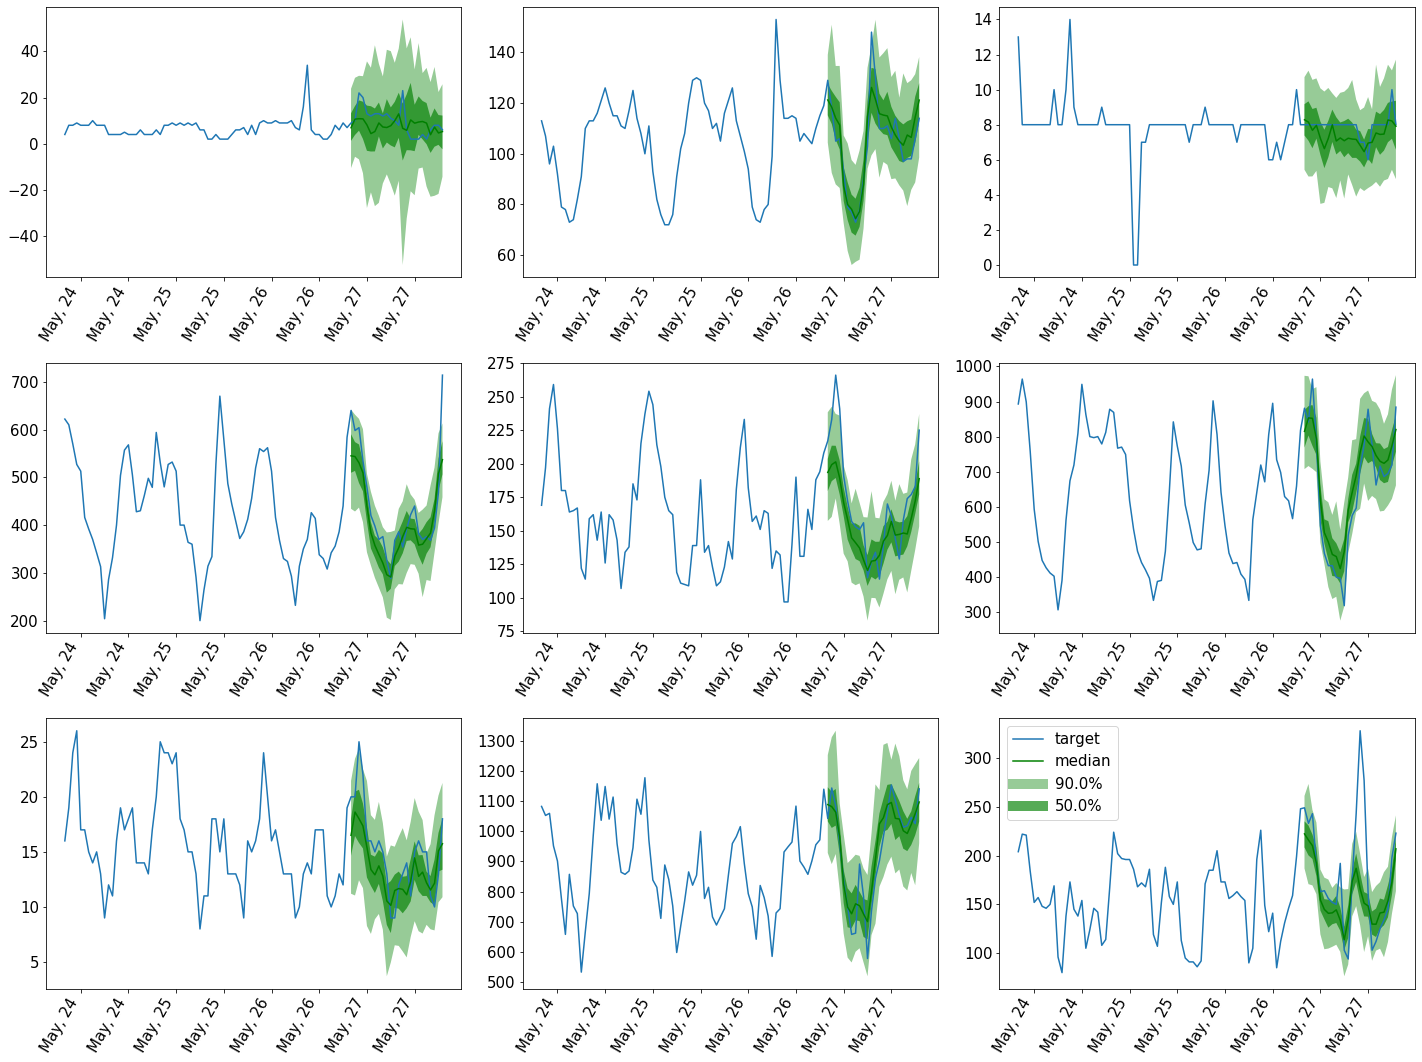

In [37]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:], label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [21]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 70
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="best")
    plt.show()

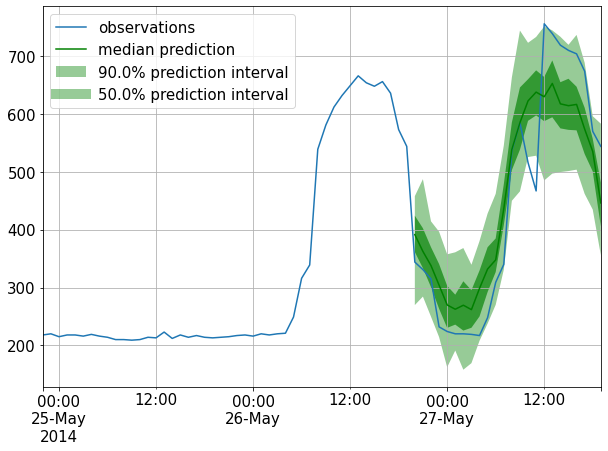

In [34]:
index = 123
plot_prob_forecasts(tss[index], forecasts[index])